In [544]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [502]:
# daily
df = pd.read_csv('/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/工作/Data Storytelling/Strava/Main data/main_daily.csv')

In [545]:
# weekly 
df = pd.read_csv('/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/工作/Data Storytelling/Strava/Main data/main_weekly.csv')

#### data cleaning

In [546]:
df = df.dropna(subset=['value'])
df = df.dropna(subset=['total_trip_count'])
df = df.dropna(subset=['rain'])
df = df[df['value'] != 0]
df= df[df['total_trip_count']!=0]

### define variables

In [308]:
# daily
Y = df['value']
X = df[['total_trip_count','rain','Area_CC','Area_S','Area_N', 'Area_NE','Weekday_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12', 'Bike_Lanes']]
X_list = ['total_trip_count','rain','Area_CC','Area_S','Area_N', 'Area_NE','Weekday_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12', 'Bike_Lanes']

In [547]:
# weekly
Y = df['value']
X = df[['total_trip_count','rain','Area_CC','Area_N','Area_SE', 'Area_NE','Bike_Lanes',
        'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12']]
X_list = ['total_trip_count','rain','Area_CC','Area_N','Area_SE', 'Area_NE','Bike_Lanes',
        'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
        'month_11', 'month_12']

In [ ]:
df

In [72]:
# Check for NaN and infinite values in X
print("NaNs or Infs in X:", np.any(np.isnan(X)) or np.any(np.isinf(X)))

# Check for NaN and infinite values in Y
print("NaNs or Infs in Y:", np.any(np.isnan(Y)) or np.any(np.isinf(Y)))


NaNs or Infs in X: False
NaNs or Infs in Y: False


### data checks

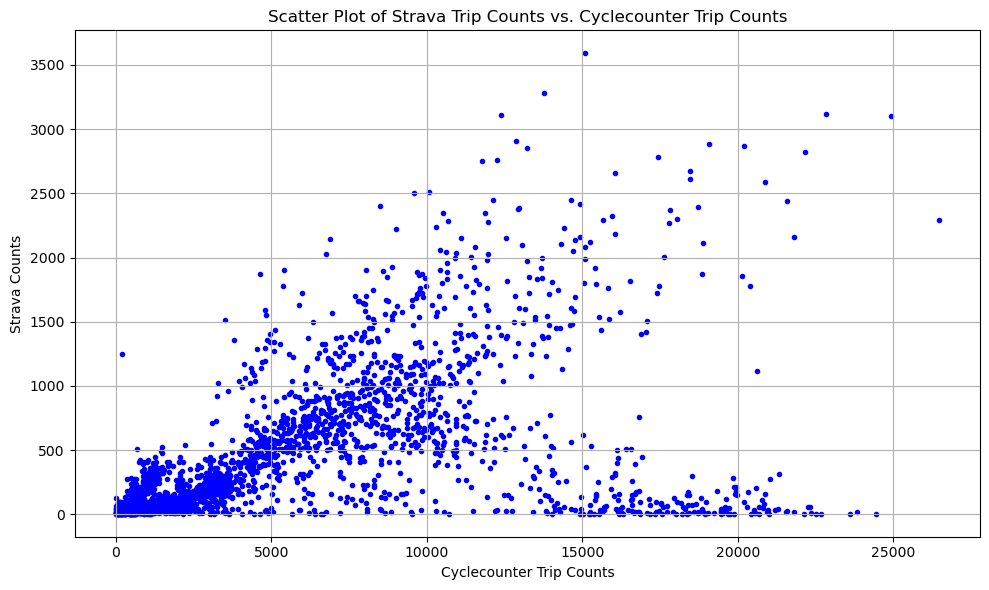

In [525]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['value'], df['total_trip_count'], color='blue', marker='.')

# Add labels and title
plt.xlabel('Cyclecounter Trip Counts')
plt.ylabel('Strava Counts')
plt.title('Scatter Plot of Strava Trip Counts vs. Cyclecounter Trip Counts')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [526]:
# Calculate VIF: Variance Inflation Factor, detects multicolinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [sm.OLS(X.iloc[:, i], sm.add_constant(X.drop(X.columns[i], axis=1))).fit().rsquared for i in range(X.shape[1])]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])
    return vif_data

vif_data = calculate_vif(X)
print("VIF Data:")
print(vif_data)

VIF Data:
            Variable       VIF
0   total_trip_count  1.295474
1               rain  1.079161
2            Area_CC  1.595107
3            Area_SE  1.515842
4            Area_NE  1.133764
5         Bike_Lanes  1.430376
6            month_2  1.732900
7            month_3  1.776983
8            month_4  1.833925
9            month_5  1.898505
10           month_6  1.773728
11           month_7  1.861805
12           month_8  1.862098
13           month_9  1.840758
14          month_10  1.974918
15          month_11  1.805512
16          month_12  1.505731
17            Area_N  1.097071


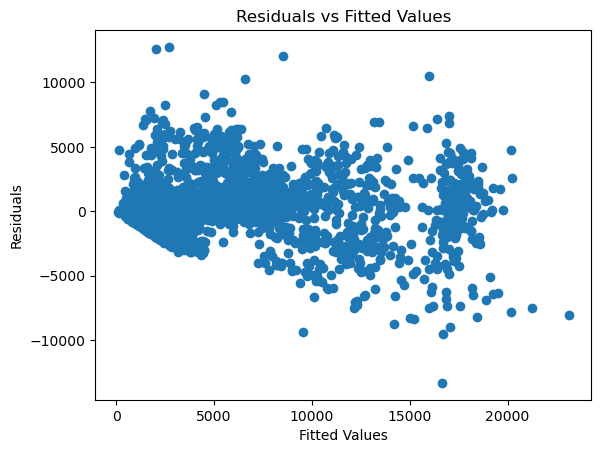

In [527]:
# Plot residuals to check for homoscedasticity:
ols_results = sm.OLS(Y, sm.add_constant(X)).fit()
residuals = ols_results.resid

plt.scatter(ols_results.fittedvalues, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


Note: heteroskedasticity issue. Will use WLS 

## Regression - TRain/TEst

In [538]:
# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.1, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

### OLS Regression
# Fit OLS model on the training data
ols_model = sm.OLS(Y_train, X_train_const)
ols_results = ols_model.fit()

# Validate the OLS model on the validation set
Y_val_pred_ols = ols_results.predict(X_val_const)
rmse_val_ols = np.sqrt(np.mean((Y_val - Y_val_pred_ols) ** 2))
mae_val_ols = mean_absolute_error(Y_val, Y_val_pred_ols)

# Test the OLS model on the test set
Y_test_pred_ols = ols_results.predict(X_test_const)
rmse_test_ols = np.sqrt(np.mean((Y_test - Y_test_pred_ols) ** 2))
mae_test_ols = mean_absolute_error(Y_test, Y_test_pred_ols)

# Print OLS training summary and accuracy
print("OLS Training Summary:")
print(ols_results.summary())

r2_ols = r2_score(Y_test, Y_test_pred_ols)
accuracy_ols = r2_ols * 100
print(f'OLS Accuracy: {accuracy_ols:.2f}%')
print(f"Validation RMSE (OLS): {rmse_val_ols:.4f}")
print(f"Test RMSE (OLS): {rmse_test_ols:.4f}")
print(f"Test MAE (OLS): {mae_test_ols:.4f}")

### WLS Regression
# Calculate residuals from the OLS model
residuals = ols_results.resid

# Handle very small residuals to avoid division by zero
residuals = np.where(residuals == 0, 1e-10, residuals)

# Calculate weights based on the residuals
weights = 1 / (residuals ** 2)
weights = np.clip(weights, 1e-5, None)  # Normalize weights if necessary

# Fit the WLS model on the training set
wls_model = sm.WLS(Y_train, X_train_const, weights=weights)
wls_results = wls_model.fit()

# Validate the WLS model on the validation set
Y_val_pred_wls = wls_results.predict(X_val_const)
rmse_val_wls = np.sqrt(np.mean((Y_val - Y_val_pred_wls) ** 2))
mae_val_wls = mean_absolute_error(Y_val, Y_val_pred_wls)

# Test the WLS model on the test set
Y_test_pred_wls = wls_results.predict(X_test_const)
rmse_test_wls = np.sqrt(np.mean((Y_test - Y_test_pred_wls) ** 2))
mae_test_wls = mean_absolute_error(Y_test, Y_test_pred_wls)

# Calculate unweighted R-squared
absolute_errors = np.abs(Y_test - Y_test_pred_wls)
absolute_error_variance = np.var(absolute_errors)
dependent_data_variance = np.var(Y_test)
unweighted_r2 = 1.0 - (absolute_error_variance / dependent_data_variance)

# Print WLS training summary and accuracy
print("WLS Training Summary:")
print(wls_results.summary())

r2_wls = r2_score(Y_test, Y_test_pred_wls)
accuracy_wls = r2_wls * 100
print(f'WLS Accuracy: {accuracy_wls:.2f}%')
print(f"Validation RMSE (WLS): {rmse_val_wls:.4f}")
print(f"Test RMSE (WLS): {rmse_test_wls:.4f}")
print(f"Test MAE (WLS): {mae_test_wls:.4f}")
print(f"Unweighted R-squared (WLS): {unweighted_r2:.4f}")

### MLE Regression (Generalized Linear Model with Gaussian Family)
# Fit the MLE model on the training data
mle_model = sm.GLM(Y_train, X_train_const, family=sm.families.Gaussian())
mle_results = mle_model.fit()

# Validate the MLE model on the validation set
Y_val_pred_mle = mle_results.predict(X_val_const)
rmse_val_mle = np.sqrt(np.mean((Y_val - Y_val_pred_mle) ** 2))
mae_val_mle = mean_absolute_error(Y_val, Y_val_pred_mle)

# Test the MLE model on the test set
Y_test_pred_mle = mle_results.predict(X_test_const)
rmse_test_mle = np.sqrt(np.mean((Y_test - Y_test_pred_mle) ** 2))
mae_test_mle = mean_absolute_error(Y_test, Y_test_pred_mle)

# Print MLE training summary and accuracy
print("MLE Training Summary:")
print(mle_results.summary())

r2_mle = r2_score(Y_test, Y_test_pred_mle)
accuracy_mle = r2_mle * 100
print(f'MLE Accuracy: {accuracy_mle:.2f}%')
print(f"Validation RMSE (MLE): {rmse_val_mle:.4f}")
print(f"Test RMSE (MLE): {rmse_test_mle:.4f}")
print(f"Test MAE (MLE): {mae_test_mle:.4f}")


OLS Training Summary:
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     529.0
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:38:51   Log-Likelihood:                -21875.
No. Observations:                2385   AIC:                         4.379e+04
Df Residuals:                    2366   BIC:                         4.390e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -

## Regression - entire dataset, WLS

In [539]:
# Add a constant term to X
X_const = sm.add_constant(X)

# Train models on the entire dataset
# OLS Model
ols_model = sm.OLS(Y, X_const)
ols_results = ols_model.fit()

# WLS Model
residuals = ols_results.resid
residuals = np.where(residuals == 0, 1e-10, residuals)
weights = 1 / (residuals ** 2)
weights = np.clip(weights, 1e-5, None)

wls_model = sm.WLS(Y, X_const, weights=weights)
wls_results = wls_model.fit()

Y_pred = wls_results.predict(X_const)
mae_wls = mean_absolute_error(Y, Y_pred)

# Calculate unweighted R-squared
absolute_errors = np.abs(Y - Y_pred)
absolute_error_variance = np.var(absolute_errors)
dependent_data_variance = np.var(Y)
unweighted_r2 = 1.0 - (absolute_error_variance / dependent_data_variance)

# Print WLS training summary and accuracy
print("WLS Training Summary:")
print(wls_results.summary())


print(f'WLS Accuracy: {accuracy_wls:.2f}%')
print(f"Validation RMSE (WLS): {rmse_val_wls:.4f}")
print(f"Test RMSE (WLS): {rmse_test_wls:.4f}")
print(f"Test MAE (WLS): {mae_wls:.4f}")
print(f"Unweighted R-squared (WLS): {unweighted_r2:.4f}")

WLS Training Summary:
                            WLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.950
Model:                            WLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2774.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:38:55   Log-Likelihood:                -23888.
No. Observations:                2650   AIC:                         4.781e+04
Df Residuals:                    2631   BIC:                         4.793e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -

In [532]:
summary = wls_results.summary()

In [533]:
# Extract tables into DataFrames
params_df = pd.DataFrame(wls_results.params, columns=['Coefficient'])
params_df['Standard Error'] = wls_results.bse
params_df['t-Statistic'] = wls_results.tvalues
params_df['P-Value'] = wls_results.pvalues

# Convert summary tables to Excel
with pd.ExcelWriter('wls_summary.xlsx') as writer:
    params_df.to_excel(writer, sheet_name='Parameters')
    
    # Optionally, extract and save additional summary statistics or tables
    # For example:
    # additional_stats_df = pd.DataFrame(...)
    # additional_stats_df.to_excel(writer, sheet_name='Additional Stats')

print("Summary has been exported to 'wls_summary.xlsx'")

Summary has been exported to 'wls_summary.xlsx'


## Robustness Check

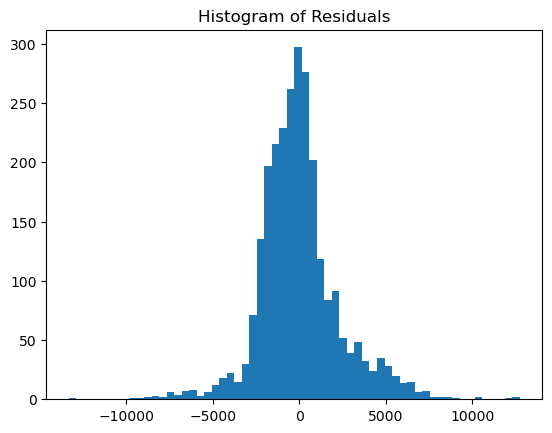

In [509]:
import scipy.stats as stats
plt.hist(wls_results.resid, bins=60)
plt.title('Histogram of Residuals')
plt.show()

/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_14732/2782127468.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, color='red')


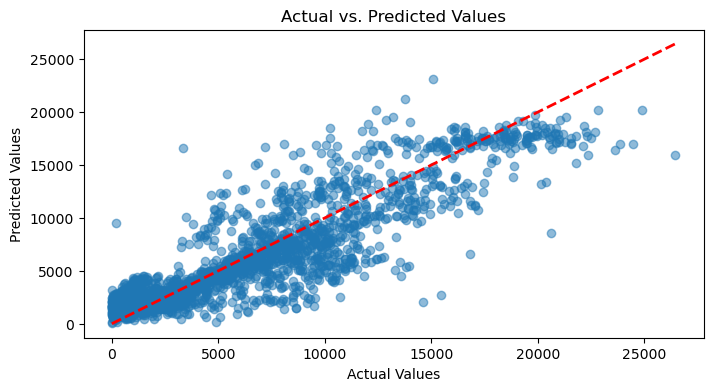

In [510]:
# Actual vs. Predicted Plot
plt.figure(figsize=(8, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

## Validation

In [511]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Function to validate and plot predictions for a specific location
def validate_and_plot(location):
    # Filter data for the specific location
    location_data = df[df['location'] == location]
    
    X_loc = location_data[X_list]
    Y_loc = location_data['value']
    time_loc = location_data['time']
    
    # Add a constant term for the intercept (ensure X_loc_const has the same shape as X_const)
    X_loc_const = sm.add_constant(X_loc, has_constant='add')
    
    # Predict using the trained model
    Y_pred_wls = wls_results.predict(X_loc_const)
    
    # Calculate the accuracy score (R-squared)
    r2 = abs(r2_score(Y_loc, Y_pred_wls)*100)
    
    # Plot the results
    plt.figure(figsize=(8, 3))
    
    # Plot original vs predicted values for the model
    plt.plot(time_loc, Y_loc, label='Ground Truth Values', color='black')
    plt.plot(time_loc, Y_pred_wls, label='Model Predictions', linestyle='--', color='green')
    
    # Add accuracy score to the plot
    plt.text(0.95, 0.05, f'Accuracy(R2) = {r2:.2f}%', fontsize=8, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    plt.xlabel('Time',fontsize=8)
    plt.ylabel('')
    plt.title(f'Original vs Predicted Values for {location}',fontsize=10)
    plt.xticks([]) 
    plt.yticks(fontsize=8) 
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()


In [512]:

# Function to validate and plot predictions for a specific location
def validate_and_plot(location):
    # Filter data for the specific location
    location_data = df[df['location'] == location]
    
    X_loc = location_data[X_list]
    Y_loc = location_data['value']
    time_loc = location_data['time']
    
    # Add a constant term for the intercept (ensure X_loc_const has the same shape as X_const)
    X_loc_const = sm.add_constant(X_loc, has_constant='add')
    
    # Predict using the trained model
    Y_pred_wls = wls_results.predict(X_loc_const)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(Y_loc, Y_pred_wls))
    
    # Normalize RMSE by the range of the actual values
    accu = 1- rmse / (Y_loc.max() - Y_loc.min())
    accu = abs(accu*100)
    # Plot the results
    plt.figure(figsize=(8, 3))
    
    # Plot original vs predicted values for the model
    plt.plot(time_loc, Y_loc, label='Ground Truth Values', color='black')
    plt.plot(time_loc, Y_pred_wls, label='Model Predictions', linestyle='--', color='green')
    
    # Add NRMSE to the plot
    plt.text(0.2, 0.9, f'accuracy = {accu:.3}%', fontsize=8, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    plt.xlabel('Time')
    plt.ylabel('Cycling Trip Volume')
    plt.title(f'Original vs Predicted Values for Location: {location}')
    plt.xticks([]) 
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()


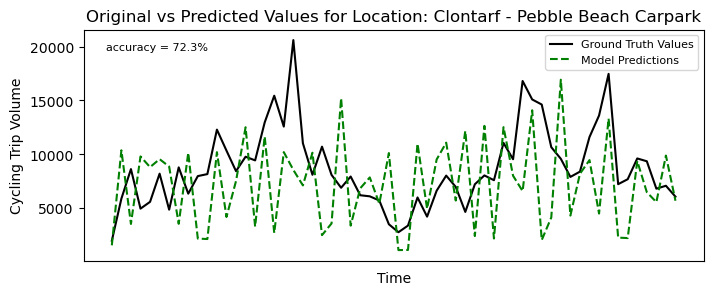

In [520]:
validate_and_plot('Clontarf - Pebble Beach Carpark')

In [ ]:
df

## Visulisation

In [43]:
import mpld3

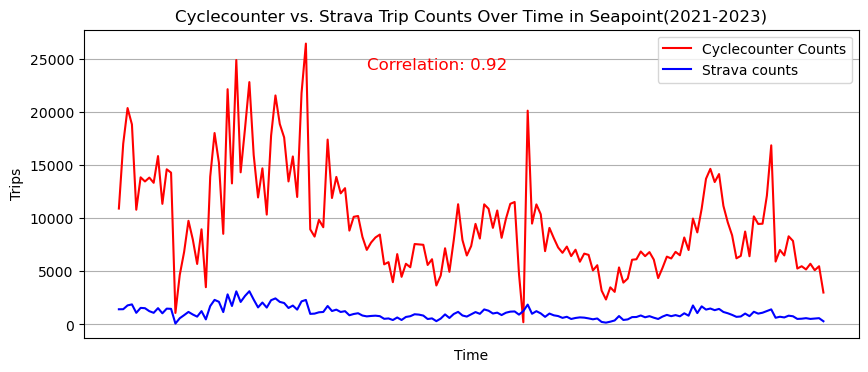

In [45]:
# Filter data based on location

df = df[df['location'] == 'Seapoint']



# Calculate correlation
correlation = df['value'].corr(df['total_trip_count'])

# Plotting the line graph
fig, ax = plt.subplots(figsize=(10, 4))

# Plot temperature
ax.plot(df['time'], df['value'], color='red', marker='', label='Cyclecounter Counts')
# Plot humidity
ax.plot(df['time'], df['total_trip_count'], color='blue', marker='', label='Strava counts')

# Adding labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Trips')
ax.set_title('Cyclecounter vs. Strava Trip Counts Over Time in Seapoint(2021-2023)')
ax.legend()

# Hide x-axis ticks
ax.set_xticks([])

# Display correlation in the top-right corner
ax.text(df['time'].max(), df['value'].max() * 0.95,
        f'Correlation: {correlation:.2f}', fontsize=12, color='red', ha='left', va='top')

# Enable grid
ax.grid(True)



In [548]:

# Calculate descriptive statistics
descriptive_stats = df[['value','total_trip_count','rain','Bike_Lanes']].describe()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
              value  total_trip_count         rain   Bike_Lanes
count   2650.000000       2650.000000  2650.000000  2650.000000
mean    5440.266119        439.569811    13.903321     0.971321
std     5297.740803        547.637901    15.153541     0.166935
min        1.000000          5.000000     0.000000     0.000000
25%     1053.250000         55.000000     2.100000     1.000000
50%     3449.000000        190.000000     8.300000     1.000000
75%     8452.250000        655.000000    19.200000     1.000000
max    26468.000000       3590.000000    73.400000     1.000000


In [209]:
import folium

# Create a map centered around Dublin
map_dublin = folium.Map(location=[53.3498, -6.2603], zoom_start=12)

# List of locations with their coordinates
locations = {
    "Clonskeagh": (53.3125, -6.2289),
    "Wyattville Rd": (53.2551, -6.1389),
    "North Strand": (53.3584, -6.2417),
    "Rock Rd": (53.3166, -6.2024),
    "N11 Inbound": (53.3094, -6.1934),
    "Rock Road Park": (53.3138, -6.2014),
    "Grange Rd": (53.2879, -6.2833),
    "Charleville Mall": (53.3555, -6.2476),
    "Guild Street": (53.3500, -6.2412),
    "Grove Road Totem": (53.3206, -6.2654),
    "Wyattville Pk": (53.2540, -6.1283),
    "N11 Outbound": (53.2978, -6.1819),
    "Wyattville Pk Steps": (53.2531, -6.1279),
    "York Road": (53.2927, -6.1516),
    "Peoples Park": (53.2922, -6.1337),
    "Seapoint": (53.3013, -6.1569),
    "Richmond": (53.3312736,-6.2671337),
    "Drumcondra": (53.3671, -6.2572),
    "Glenageary": (53.2783, -6.1214),
    "Clontarf - Pebble Beach Carpark": (53.3619, -6.2033),
    "Griffith Avenue": (53.3727, -6.2528)
}

# Add each location to the map with a marker
for location, coords in locations.items():
    folium.Marker(
        location=coords,
        popup=location,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map_dublin)

# Display the map
map_dublin.save("dublin_map.html")

# Optionally, to display it directly in a Jupyter notebook, use:

# display(map_dublin)


## Visualise different routes

In [540]:
df = pd.read_csv('RBA and Validation/weekly prediction.csv')

/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_14732/2100063783.py:6: UserWarning: Parsing '17/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_14732/2100063783.py:6: UserWarning: Parsing '24/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_14732/2100063783.py:6: UserWarning: Parsing '31/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/3k/33cdns495m3g6450_3r7_gvh0000gn/T/ipykernel_14732/2100063783.py:6: UserWarning: Parsing '14/02/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['date'] =

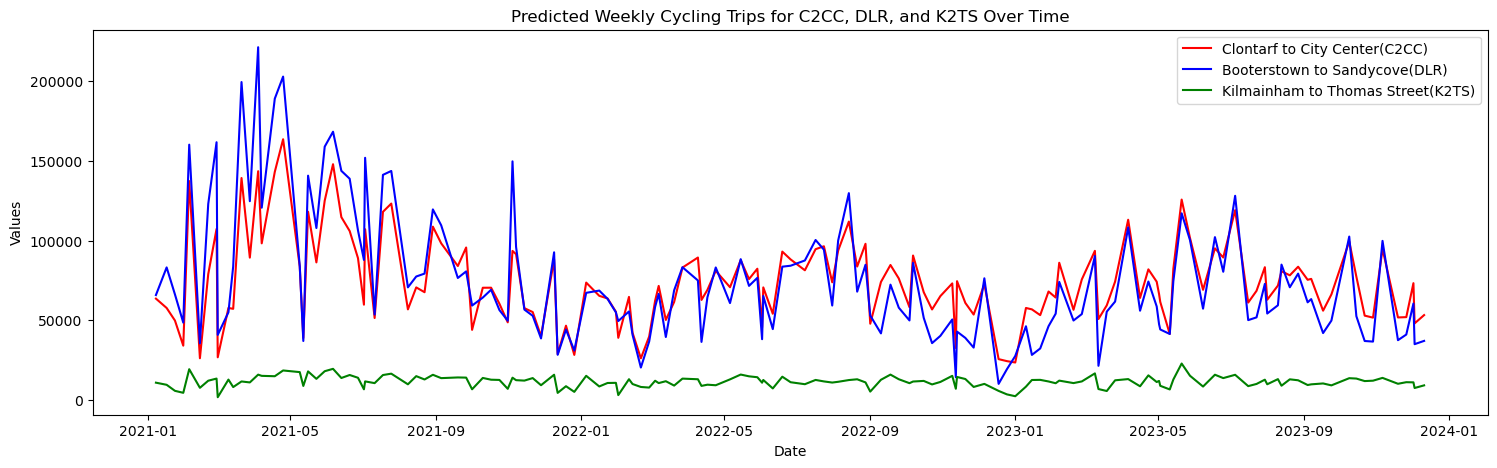

In [541]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' has columns 'date', 'C2CC', 'DLR', 'K2TC'
# Convert 'date' to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Set the plot size
plt.figure(figsize=(18, 5))

# Plot each column on the same line chart
sns.lineplot(data=df, x='date', y='C2CC', color = 'red', label='Clontarf to City Center(C2CC)')
sns.lineplot(data=df, x='date', y='DLR', color = 'blue', label='Booterstown to Sandycove(DLR)')
sns.lineplot(data=df, x='date', y='K2TC', color = 'green', label='Kilmainham to Thomas Street(K2TS)')

# Add title and labels
plt.title('Predicted Weekly Cycling Trips for C2CC, DLR, and K2TS Over Time')
plt.xlabel('Date')
plt.ylabel('Values')

# Display the legend
plt.legend()

# Show the plot
plt.show()